# Waze Analysis

# Imports

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [53]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)


def k_means_clustering(complete_df, missing_values_df, preprocessor, features):
    model = KMeans(n_clusters=2, random_state=42)
    pipeline = create_sklearn_pipeline(preprocessor, model)
    
    complete_df['cluster'] = pipeline.fit_predict(complete_df.drop('label', axis=1))
    
    retained_count = complete_df[complete_df['label'] == 'retained']['cluster'].value_counts()
    churned_count = complete_df[complete_df['label'] == 'churned']['cluster'].value_counts()
    print("Retained in each cluster:", retained_count)
    print("Churned in each cluster:", churned_count)
    
    cluster_to_target = complete_df.groupby('cluster')['label'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
    
    missing_values_df['cluster'] = pipeline.predict(missing_values_df.drop('label', axis=1))
    missing_values_df['label'] = missing_values_df['cluster'].map(cluster_to_target)
    
    final_df = pd.concat([complete_df, missing_values_df])
    
    pca = PCA(n_components=2)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    reduced_data = pipeline.fit_transform(complete_df.drop(['label', 'cluster'], axis=1))

    complete_df['pca_one'] = reduced_data[:, 0]
    complete_df['pca_two'] = reduced_data[:, 1]

    plt.figure(figsize=(10, 6))
    for cluster in complete_df['cluster'].unique():
        cluster_data = complete_df[complete_df['cluster'] == cluster]
        plt.scatter(cluster_data['pca_one'], cluster_data['pca_two'], label=f'Cluster {cluster}')

    plt.title('Cluster Visualization with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
        
    return final_df

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/waze_dataset.csv")
df

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone
14995,14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android
14996,14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone
14997,14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone


In [4]:
df.drop("ID", axis=1, inplace=True)

# Check For Nulls / Dupes

In [7]:
check_for_nulls_dupes(df)

The amount of Null Values: label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

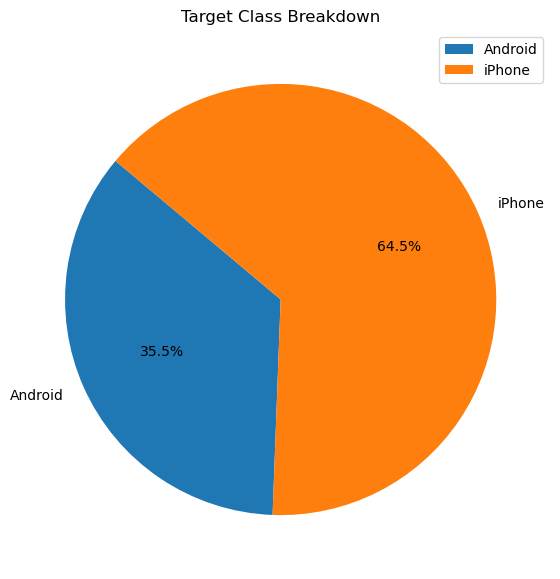

In [10]:
check_class_imbalance(df["device"])

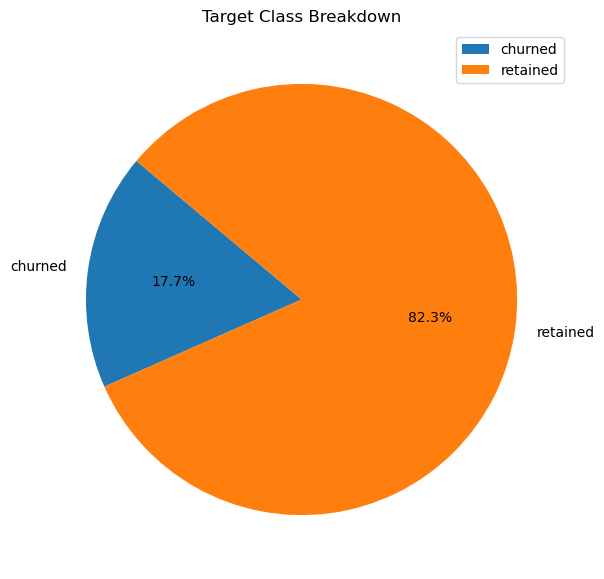

In [11]:
check_class_imbalance(df["label"].dropna())

# Create Preprocessor

In [39]:
numeric_types = df.select_dtypes(exclude="object")
categorical_types = df.select_dtypes(include="object").drop("label", axis=1)

preprocessor = create_column_transformer(categorical_types.columns, numeric_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['device'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object'))])

# Imbalanced Dataset

In [26]:
missing_values = df[df.isna().any(axis=1)]

In [27]:
missing_values

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
77,NaN,63,50,133.104155,783,201,0,2649.015822,1517.209970,19,13,iPhone
80,NaN,116,93,436.060183,1584,283,62,4183.409514,3121.889952,18,15,iPhone
98,NaN,78,64,583.492789,3414,0,0,1811.140893,642.189122,12,11,Android
111,NaN,106,102,113.379056,2228,14,0,2817.481840,2011.724274,17,13,Android
142,NaN,32,26,222.129310,208,55,10,2459.816477,874.427617,11,7,iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
14941,NaN,191,160,485.328204,1287,25,0,6468.181924,3466.104564,14,14,iPhone
14943,NaN,48,38,96.797017,555,0,6,8266.129497,5902.351711,19,19,iPhone
14945,NaN,34,29,134.416604,1643,268,2,4554.007843,1579.211201,18,17,Android
14972,NaN,220,181,256.212166,1718,360,23,5586.913459,4104.440202,19,18,iPhone


# 700 Rows Are missing a target column. We could do an unsupervised learning model to cluster these values into the right buckets.

In [28]:
missing_values.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [35]:
complete_df = df[df["label"].notna()]
complete_df

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
...,...,...,...,...,...,...,...,...,...,...,...,...
14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone
14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android
14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone
14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone


# Kmean Clustering Algorithm

Retained in each cluster: 1    6330
0    5433
Name: cluster, dtype: int64
Churned in each cluster: 1    1338
0    1198
Name: cluster, dtype: int64


/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_43472/3053245448.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['cluster'] = pipeline.fit_predict(complete_df.drop('label', axis=1))
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_43472/3053245448.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values_df['cluster'] = pipeline.predict(missing_values_df.drop('label', axis=1))
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_43472/3053245448.py:76: S

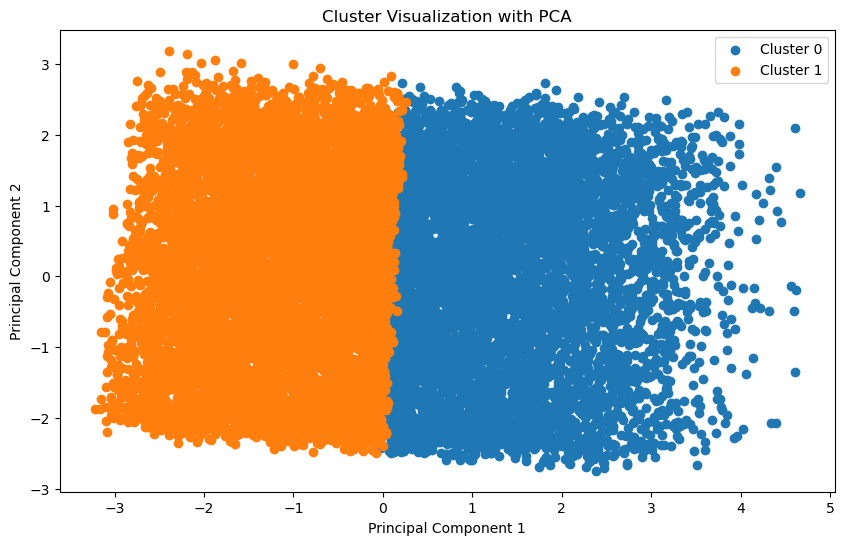

In [54]:
features = [col for col in df.columns if col != "label"]
test_df = k_means_clustering(complete_df, missing_values, preprocessor, features)

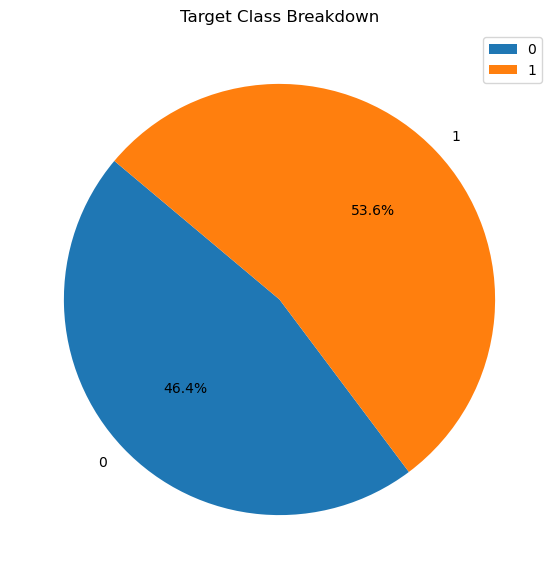

In [55]:
check_class_imbalance(test_df["cluster"])